# DSCI100-009-18 FINAL GROUP PROJECT

### Amelia Zhang, Jaza Khan, Sora Takamura, Yolanda Peng

## **Introduction**

Understanding how players engage with online games can help developers and computer science researchers design better systems and keep players active on the server. The UBC team of computer science researchers, led by Frank Wood, has created a Minecraft server that records detailed behavioural data from players who have different backgrounds. These data provide a unique opportunity to study how different players interact with the game. 

Newsletter subscription can serve as an indicator of players’ interest and engagement. Therefore, identifying which types of players are most likely to subscribe and understanding how their backgrounds and in-game behaviours differ is valuable for improving recruitment strategies. 

Our research question is:

> Can a player's experience level and played hours predict whether a player subscribes to a game-related newsletter?

To answer this question, we are using the dataset collected from the Minecraft research server, which contains players' basic information and behavioural variables.

## **Data Description**

This dataset contains `196 observations` and `7 variables`. Each row represents data from a single player, including their personal details and information when they play Minecraft.
The purpose of this dataset is to explore what player characteristics are more predictive of newsletter subscription. 

| Variable | Type | Description | Summary / Mean Value | Possible Issues |
|----------|------|-------------|----------------------|-----------------|
| `experience`| categorical | player's level of experience. | 5 levels: Beginner, Amateur, Regular, Veteran, and Pro. Most players fall into the Amateur group. |     |
| `subscribe`| categorical | TRUE if the player subscribed to the newsletter; FALSE otherwise. | TRUE: 142, FALSE: 52 |     |
| `hashedEmail` | character | anonymized player's email address. | NA |     |
| `played_hours` | numerical | total hours each player has spent playing the game. | mean: 5.90 (hours) | There seem to be outliers which may skew results hence data may need to be standardized. |
| `name` | character | name | NA |     |
| `gender` | categorical | gender. | This dataset has six gender identities, where the majority of players are male. |     |
| `Age` | numerical | age. | mean: 21.14 (years) | Type may need to be changed to type Integer to optimize for memory since that will not impact data regardless. |

In this project, the **response variable** is `subscribe`, which indicates whether a player has subscribed to the newsletter or not. The **explanatory variables** are `experience` and `played_hours` because these variables represent a player's characteristics and activity levels that would affect their decision to subscribe. Those irrelevant columns such as `hashedEmail`, `name`, `Age`, and `gender` will be removed in the data wrangling process. This dataset has behavioral information for each player, which makes it possible to examine subscription patterns across different player types and activity levels.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Loading the dataset

In [2]:
players <- read_csv("https://raw.githubusercontent.com/yolandapengx/dsci-100-project-009-18/refs/heads/main/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## Data Wrangling

In [3]:
# selecting only the relevant columns/variables
players_clean <- players |>
    select(experience,
           subscribe,
           played_hours) |>
# # removing rows with missing values
#     filter(!is.na(Age)) |>
# # converting Age to integer type
#     mutate(Age = as.integer(Age)) |>
# changing true/false vals to subscribed/not-subscribed for easier readability
    mutate(subscribe = as.character(subscribe)) |>
    mutate(across('subscribe', str_replace, 'TRUE', 'subscribed')) |>
    mutate(across('subscribe', str_replace, 'FALSE', 'not subscribed')) |>
# converting categorial variables to factors
    mutate(subscribe = as_factor(subscribe)) |>
# converting experience to numerical values
    mutate(experience_num = case_when(
                experience == "Beginner" ~ 1,
                experience == "Regular" ~ 2,
                experience == "Amateur" ~ 3,
                experience == "Veteran" ~ 4,
                experience == "Pro" ~ 5))
players_clean

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across("subscribe", str_replace, "TRUE", "subscribed")`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


experience,subscribe,played_hours,experience_num
<chr>,<fct>,<dbl>,<dbl>
Pro,subscribed,30.3,5
Veteran,subscribed,3.8,4
Veteran,not subscribed,0.0,4
⋮,⋮,⋮,⋮
Amateur,not subscribed,0.0,3
Amateur,not subscribed,2.3,3
Pro,subscribed,0.2,5


# Methods

To investigate whether a player’s experience level and total played hours can predict newsletter subscription, we carried out exploratory visualization and built a k-nearest neighbours (KNN) classification model.

### Data Wrangling

We selected only the variables relevant to our research question: experience, played_hours, and subscribe.
Other variables (hashedEmail, name, age, gender) were removed as they were either irrelevant or incomplete.

The subscribe variable was recoded from logical (TRUE/FALSE) to a more interpretable factor (subscribed / not subscribed).
We also retained the original experience categories but created an additional numeric version (experience_num) to allow KNN to compute distances.

### Exploratory Visualization

We generated several plots to understand the relationships in the data:

1, A proportional bar chart of subscription status across experience levels

2, A bar chart comparing average played hours for subscribed vs. non-subscribed players

3, A scatter plot of played hours vs. experience level

These visualizations helped inform the choice of predictors for the classification model.

### KNN Classification Model

The cleaned dataset was split into training (80%) and testing (20%) sets using stratified sampling.

Because KNN is sensitive to predictor scale, we applied centering and scaling to experience_num and played_hours.
We tuned the number of neighbours (k) using 5-fold cross-validation on k = 2–6 using accuracy as the metric.

The highest cross-validation accuracy occurred at k = 6, which we selected for the final model.
We then evaluated model performance on the testing set using the overall accuracy and confusion matrix.

These results allowed us to assess how well experience and played hours predict newsletter subscription.


# Results

## 1. Summary of Player Characteristics

After cleaning the data by removing rows with missing age values and keeping
only relevant variables (experience, subscribe, played_hours),
we obtained a dataset with 196 players.

The summary statistics show that the the average total played hours is about 5.8 hours. Most players are
classified as Amateur in terms of experience. These descriptive results indicate that the dataset contains a moderately active player population, suitable for modelling newsletter subscription behaviour.

### Mean Values

In [4]:
players_mean <- players_clean |>
select(played_hours) |>
summarize(Mean_Played_Hours = mean(played_hours, na.rm = TRUE))

players_mean

Mean_Played_Hours
<dbl>
5.845918


## 2. Subscription Proportions Across Experience Levels

*Figure 1*  shows the proportion of players who subscribed to the newsletter
for each experience level.

Surprisingly, players with an regular, beginner, or amateur experience have the highest ratios of subscribed vs. not subscribed, with regular having the greatest proportion of subscribers compared to non-subscribers. It appears that as players get more and more experienced, they are in fact less likely to subscribe to the newsletter, perhaps due to a lack of need for it.


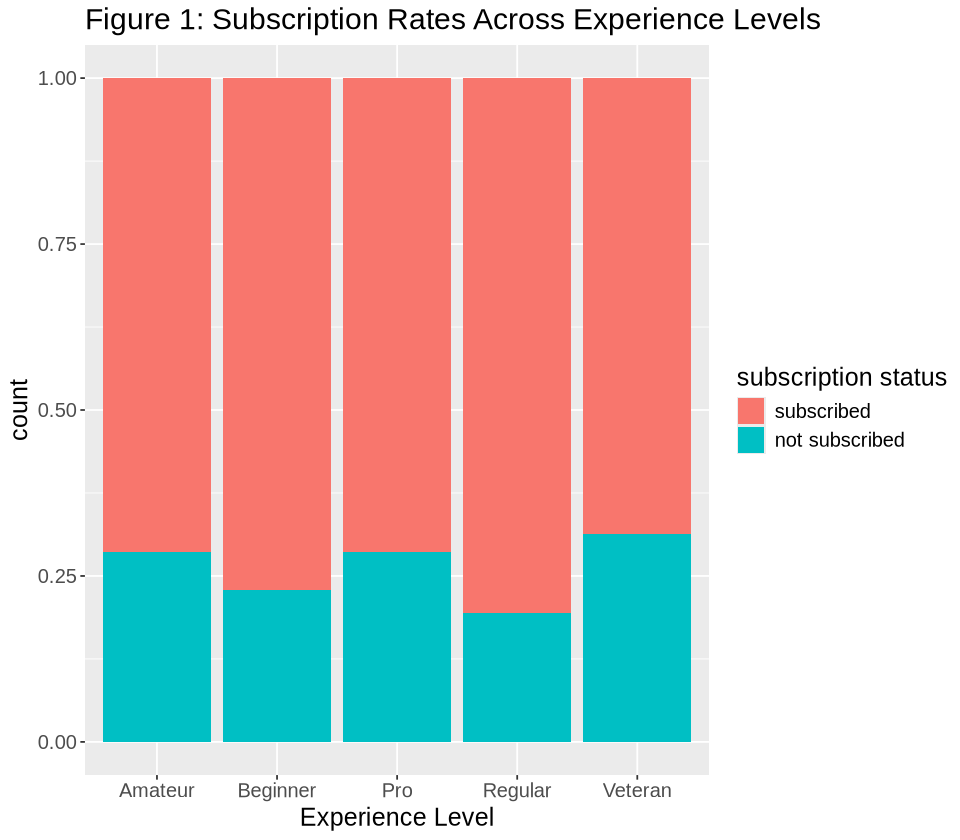

In [5]:
options(repr.plot.width = 8, repr.plot.height = 7)

fig1 <- players_clean |>
            group_by(experience) |>
            ggplot(aes(x = experience, fill = subscribe)) + 
            geom_bar(position = "fill") +
            labs(title = "Figure 1: Subscription Rates Across Experience Levels",
       x = "Experience Level",
       fill = "subscription status") +
  theme(text = element_text(size = 15))
fig1

## 3. Played Hours by Subscription Status

**Figure 2** compares the distribution of total played hours between players
who subscribed and those who did not.

Subscribers tend to have much higher median played hours (about 8 hours) whereas, in contrast, non-subscribers generally
show lower average playtime (less than 1 hour). This pattern suggests that players
who invest more time in the game are more likely to subscribe to the
newsletter, consistent with the idea that higher engagement leads to greater
interest in game-related updates.

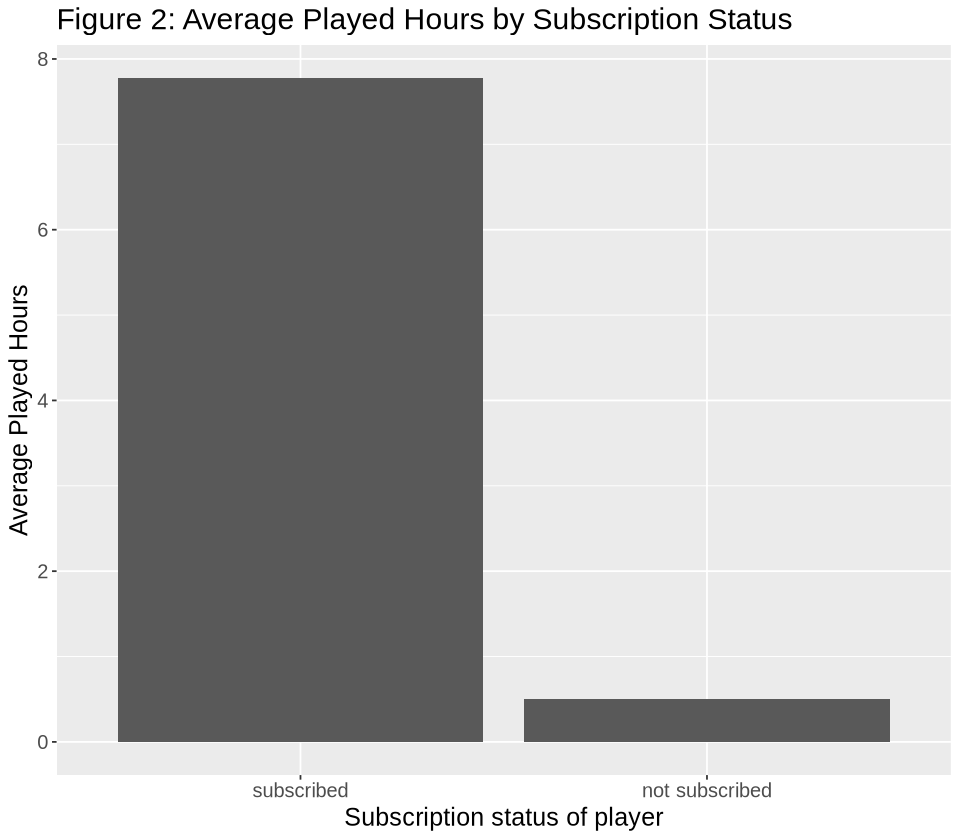

In [6]:
fig2 <- players_clean |>
        group_by(subscribe) |>
        summarize(average_played_hours = mean(played_hours)) |>
  ggplot(aes(x = subscribe, y = average_played_hours)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 2: Average Played Hours by Subscription Status",
       x = "Subscription status of player",
       y = "Average Played Hours") +
  theme(text = element_text(size = 15))

fig2

## 4. Preliminary Scatter Plot of Playtime versus Experience Level

This is a preliminary visualization made to help us see the relationship between players' number of played hours and their experience level, as well as if there are any patterns in how the subscription status is colored across the graph. It will help us when we begin our KNN classification predictive analysis.

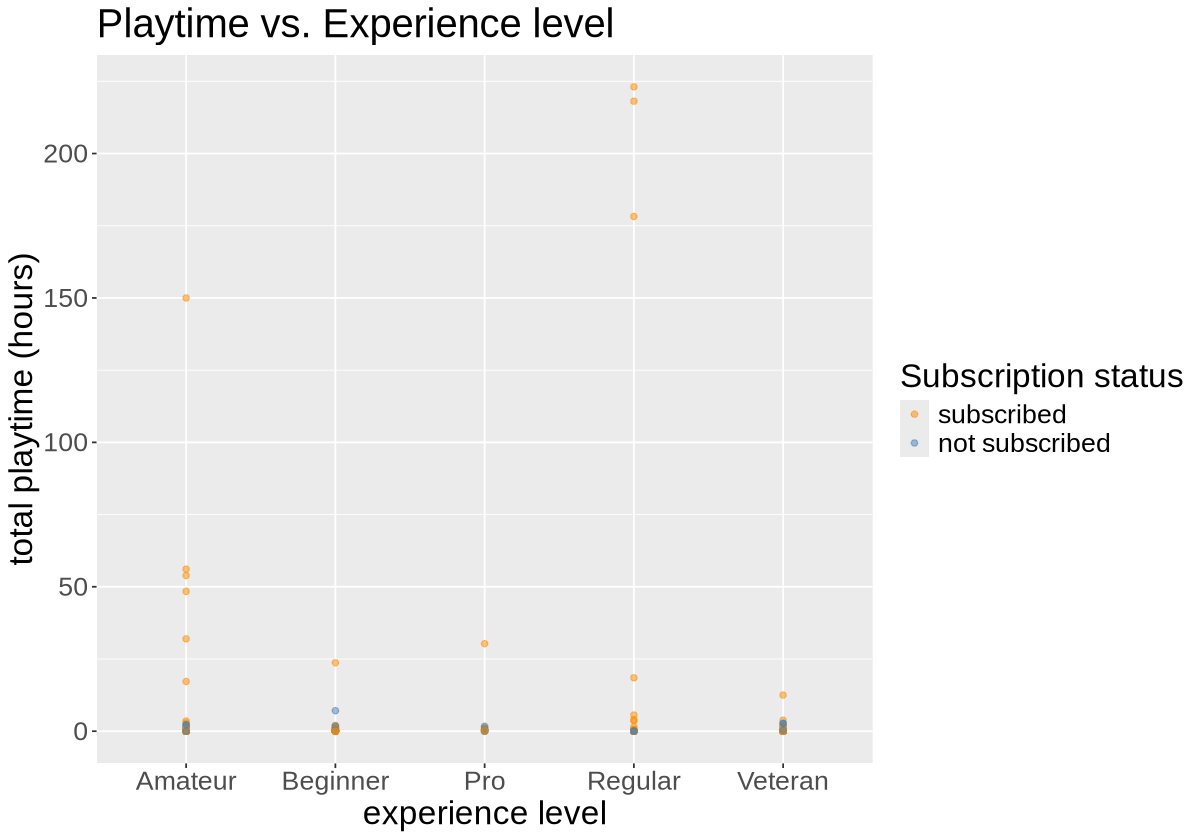

In [11]:
options(repr.plot.width = 10, repr.plot.height = 7)

players_scatter <- players_clean |>
  ggplot(aes(x = experience, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(color = "Subscription status", x = "experience level", y = "total playtime (hours)", title = "Playtime vs. Experience level") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 20))

players_scatter

## 4. K Nearest Neighbors Classification Model

To investigate which variables predict newsletter subscription, we fitted a
k-nearest neighbours classification model using subscribe as the response variable and
experience and played_hours as predictors.

In [8]:
set.seed(123)

# Splitting original data
data_split <- initial_split(players_clean, prop = 0.8, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

# creating recipe
players_recipe <- recipe(subscribe ~ experience_num + played_hours,
                     data = train_data) |>
                     step_scale(all_predictors()) |>
                     step_center(all_predictors())

### Model Performance/Finding Best K-value

To test the prediction accuracy of our knn classifier, we will be using 5-fold cross validation on our training data to get an estimated accuracy percentage for how well our model can predict whether or not a player is subscribed to the newsletter for different values of k. We will then choose the k value that gives us the higher average accuracy to complete our final predictive analysis.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.4804435,5,0.03541106,Preprocessor1_Model1
3,accuracy,binary,0.5058468,5,0.03767573,Preprocessor1_Model2
4,accuracy,binary,0.4933468,5,0.03203616,Preprocessor1_Model3
5,accuracy,binary,0.5127016,5,0.01639027,Preprocessor1_Model4
6,accuracy,binary,0.5189516,5,0.01912243,Preprocessor1_Model5


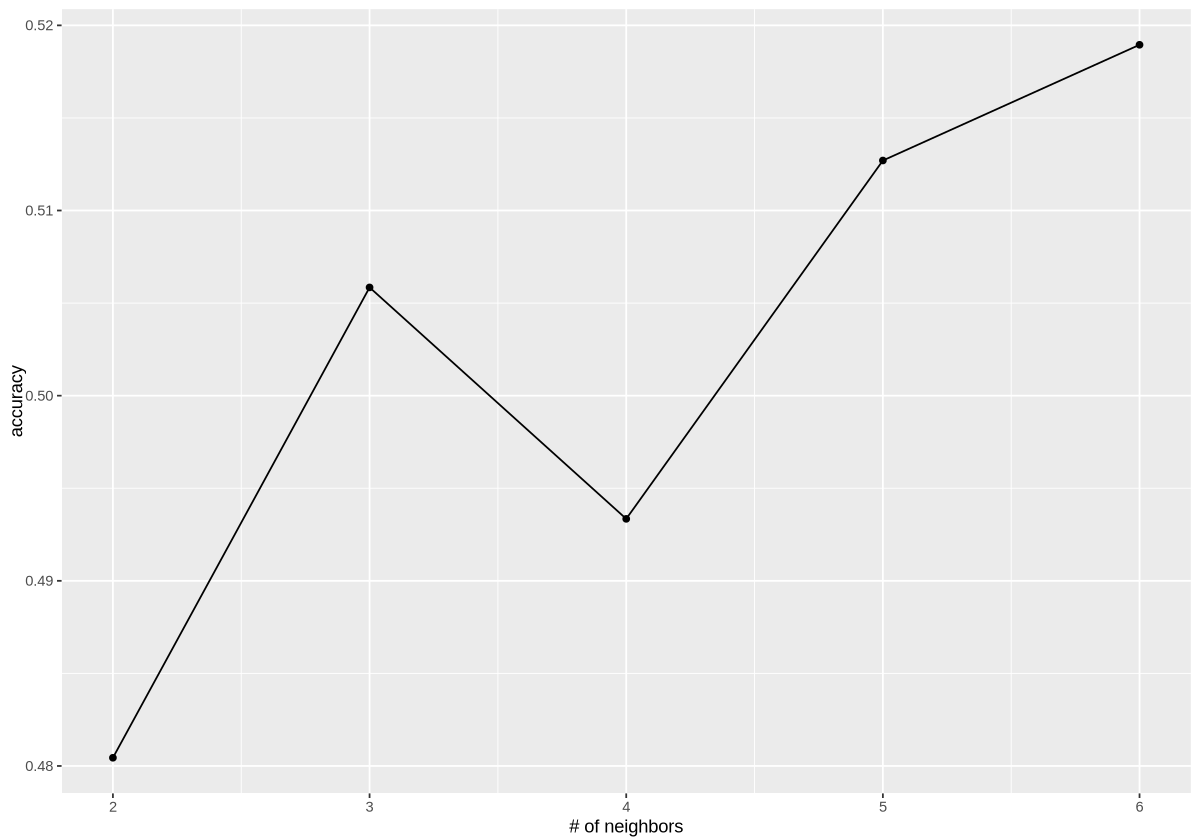

In [9]:
set.seed(123)
# cross validation to find the predictive accuracy

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

training_recipe <- recipe(subscribe ~ played_hours + experience_num,
                        data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

training_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_results <- workflow() |>
                 add_recipe(training_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = training_vfold, grid = tibble(neighbors = c(2,3,4,5,6))) |>
                 collect_metrics() |>
                 filter(.metric == "accuracy")
knn_results

cross_val_plot <- ggplot(knn_results, aes(y = mean, x = neighbors)) +
                geom_point() +
                geom_line() +
                labs(y = "accuracy", x = "# of neighbors")
cross_val_plot

From the plot above, we can see that the number of neighbours with the highest accuracy is k = 6, therefore that is what we will choose when completing the formal analysis.

### Creating Confusion Matrix and Using Model on Test Data

In [10]:
set.seed(123)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |> # using the k-value we found from our analysis above
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = train_data)
players_fit

players_predictions <- predict(players_fit, test_data) |>
                    bind_cols(test_data)
players_predictions

players_metrics <- metrics(players_predictions, truth = subscribe, estimate = .pred_class) |>
                filter(.metric == "accuracy")
players_metrics

players_conf_mat <- conf_mat(players_predictions, truth = subscribe, estimate = .pred_class)
players_conf_mat

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3333333
Best kernel: rectangular
Best k: 6

.pred_class,experience,subscribe,played_hours,experience_num
<fct>,<chr>,<fct>,<dbl>,<dbl>
subscribed,Veteran,subscribed,3.8,4
not subscribed,Veteran,not subscribed,0.0,4
not subscribed,Amateur,not subscribed,0.0,3
⋮,⋮,⋮,⋮,⋮
subscribed,Pro,not subscribed,0.2,5
not subscribed,Amateur,not subscribed,0.0,3
not subscribed,Amateur,subscribed,0.0,3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.475


                Truth
Prediction       subscribed not subscribed
  subscribed             12              4
  not subscribed         17              7

# Discussion

## Summary of Findings

Across all analyses, several consistent patterns emerge:

- Players with **more played hours** are more likely to subscribe to the
  newsletter, indicating that in-game engagement strongly relates to
  external engagement.
- Players with **lower experience levels** (such as Regular and Beginner) show
  higher subscription rates than Veterans and Pros.
- The k-nearest neighbors model achieves **weak predictive performance** of about 48% accuracy,
  suggesting that player characteristics and activity levels do not necessarily contain useful
  information for predicting subscription, and that likey other unobserved factors
  likely play a role.

Overall, the results support the idea that more active
players with less experience are more likely to subscribe to game-related newsletters. However, 
it also demonstrates that while there is a correlation between these two variables and subscription status,
it doesn't necessarily mean causation, as we can see from the weak predictive performance result. This
provides useful guidance for targeting communication or designing
engagement strategies for different types of players.

## Expectations vs. Results

The results we uncovered through our data analysis align relatively closely with what we expected to find. It stands to reason that individuals with higher playing times (i.e., greater in-game engagement) would have a higher level of interest in the newsletter. However, it did come as a surprise that higher experience levels were negatively correlated with subscriptions. Intuitively, one might assume that as players become more experienced, they become more engaged and therefore more interested in game-related updates. The weaker effects of players’ age and gender on subscription were also somewhat surprising but understandable, as playtime and experience can vary widely among individuals of different ages and gender identities, making these variables less reliable indicators of engagement.

## Impact

The knowledge gained through this analysis could have several meaningful impacts. First, our findings may help newsletter writers better understand their audience, which would allow them to tailor content to the interests of groups most likely to subscribe. This insight could potentially guide decisions about what topics to highlight, what types of events to promote, and what tone or style to use so that it will resonate with specific player groups better. Second, our results may support more targeted promotion strategies. For example, players with higher playtime but lower experience (more likely to subscribe) could be prioritized for promotional notifications or engagement campaigns. On the other hand, these findings clearly show a need to consider how newsletters might be changed/improved upon in order to better appeal to more experienced players as well as ones with lower played hours, especially those that already log higher played hours and have high experience levels. If the newsletter is altered to appeal to these subgroups, the company could broaden the audience significantly and hence, increase the rates of subscriptions accordingly. Lastly, our model’s weak predictive performance suggests that important determinants of newsletter subscription rates were not provided in the factors present in the data set, which could be used as a basis to further investigate factors that influence subscription decisions more significantly, which then could be used for more informed data analysis.

## Future Questions

Expanding on the last point made in the "Impacts" section of this report, our weak-moderate predictive performance ability stimulates the question of what other factors could act as a possible contributor to subscription status other than experience and played hours, and more so than age and gender. It also generates the question of what can be changed about the newsletter so that it appeals to players with less played hours and/or more experience as well? It may be of interest to investigate whether this lack of subscriptions from individuals with less played hours is solely due to the fact that they may just be inherently less interested in the game itself, or if it's because they feel specifically that the newsletter doesn't appeal to their more beginner level interests, whether it be due to a sense of exclusivity, lack of knowledge regarding certain game terminology, or lack of events and information that benefits them. On the other hand, it may be of interest to investigate this lack of subscriptions from individuals with higher experience levels is and whether it is because the players feel knowledgeable enough and hence see little value in the newsletter or there is something more to it. Overall, these questions could help provide meaningful to look into further in order to benefit player engagement, inclusivity, and the overall success of the newsletter in spreading information. 